In [1]:
# imports

# python standard libraries
import os
import random

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf

import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.6.2
keras.__version__: 2.6.0


In [2]:
data_dir = '../data/training_data/training_data'
file_list = os.listdir(data_dir)

In [3]:
df = pd.read_csv('../data/training_norm.csv')
df.head()

,image_id,angle,speed
0,1,0.4375,0.0000
1,2,0.8125,1.0000
2,3,0.4375,1.0000
3,4,0.6250,1.0000
4,5,0.5000,0.0000


In [4]:
image_id = []
image_name = []
image_path = []
image_array = []
file_size = []
for filename in file_list:
    im = cv2.imread(data_dir + '/' + filename)
    image_name.append(filename)
    image_array.append(im)
    image_path.append(data_dir + '/' + filename)
    file_size.append(os.path.getsize(data_dir + '/' + filename))
    image_id.append(int(filename.split('.')[0]))

In [5]:
data = {
    'image_id': image_id,
    'image_name': image_name,
    'image': image_array,
    'image_path': image_path,
    'file_size': file_size
}

In [6]:
new_df = pd.DataFrame(data)
new_df.head()

,image_id,image_name,image,image_path,file_size
0,4636,4636.png,"[[[5, 6, 10], [8, 9, 14], [9, 11, 18], [9, 11, 18], [10, 13, 17], [10, 13, 17], [12, 14, 16], [11, 12, 14], [9, 11, 18], [8, 10, 16], [7, 9, 11], [5, 7, 9], [3, 5, 5], [1, 4, 3], [3, 5, 5], [6, 9,...",../data/training_data/training_data/4636.png,121497
1,1168,1168.png,"[[[205, 182, 176], [205, 182, 176], [205, 183, 182], [203, 180, 180], [210, 180, 174], [211, 181, 175], [206, 184, 176], [206, 184, 176], [212, 180, 181], [211, 179, 180], [212, 179, 175], [213, 1...",../data/training_data/training_data/1168.png,116939
2,8651,8651.png,"[[[3, 6, 3], [3, 6, 3], [2, 7, 4], [2, 7, 4], [3, 9, 5], [3, 9, 5], [0, 9, 5], [0, 9, 5], [2, 7, 4], [2, 7, 4], [5, 8, 5], [5, 8, 5], [5, 8, 5], [5, 8, 5], [5, 8, 5], [5, 8, 5], [3, 8, 7], [3, 8, ...",../data/training_data/training_data/8651.png,114345
3,10071,10071.png,"[[[11, 9, 21], [4, 2, 14], [15, 10, 38], [38, 33, 61], [102, 106, 100], [0, 4, 0], [23, 25, 13], [18, 20, 8], [16, 14, 12], [16, 14, 12], [15, 16, 6], [15, 16, 6], [14, 15, 5], [15, 16, 6], [12, 6...",../data/training_data/training_data/10071.png,123177
4,4191,4191.png,"[[[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [254, 251, 255], [255, 253, 254], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 2...",../data/training_data/training_data/4191.png,122472


In [7]:
merged_df = pd.merge(df, new_df, how='left', on='image_id')
merged_df.head()

,image_id,angle,speed,image_name,image,image_path,file_size
0,1,0.4375,0.0000,1.png,"[[[134, 135, 139], [134, 135, 139], [136, 139, 139], [136, 139, 139], [126, 140, 144], [128, 142, 147], [136, 143, 149], [139, 146, 151], [147, 157, 153], [147, 157, 153], [140, 145, 156], [134, 1...",../data/training_data/training_data/1.png,128113
1,2,0.8125,1.0000,2.png,"[[[160, 144, 142], [155, 140, 138], [156, 136, 128], [165, 144, 136], [109, 113, 103], [106, 109, 100], [108, 109, 107], [113, 114, 111], [120, 114, 120], [124, 117, 123], [128, 122, 114], [129, 1...",../data/training_data/training_data/2.png,127064
2,3,0.4375,1.0000,3.png,"[[[65, 40, 60], [66, 41, 61], [63, 53, 55], [69, 59, 61], [61, 57, 67], [65, 62, 72], [80, 64, 66], [80, 64, 66], [77, 67, 69], [12, 2, 3], [59, 63, 53], [255, 255, 249], [255, 255, 255], [255, 25...",../data/training_data/training_data/3.png,126239
3,4,0.6250,1.0000,4.png,"[[[16, 12, 8], [5, 2, 0], [80, 64, 65], [135, 119, 119], [128, 108, 102], [128, 108, 102], [132, 110, 100], [133, 111, 101], [128, 111, 100], [126, 110, 99], [124, 110, 99], [126, 111, 100], [126,...",../data/training_data/training_data/4.png,113880
4,5,0.5000,0.0000,5.png,"[[[189, 163, 165], [190, 164, 166], [203, 170, 164], [218, 186, 179], [196, 172, 167], [194, 171, 166], [194, 175, 158], [194, 175, 158], [192, 169, 171], [197, 174, 175], [201, 176, 169], [201, 1...",../data/training_data/training_data/5.png,125944


In [8]:
cleaned_df = merged_df[merged_df['file_size'] > 0]
cleaned_df['speed'] = cleaned_df['speed'].astype(np.int32)
cleaned_df.head()

,image_id,angle,speed,image_name,image,image_path,file_size
0,1,0.4375,0,1.png,"[[[134, 135, 139], [134, 135, 139], [136, 139, 139], [136, 139, 139], [126, 140, 144], [128, 142, 147], [136, 143, 149], [139, 146, 151], [147, 157, 153], [147, 157, 153], [140, 145, 156], [134, 1...",../data/training_data/training_data/1.png,128113
1,2,0.8125,1,2.png,"[[[160, 144, 142], [155, 140, 138], [156, 136, 128], [165, 144, 136], [109, 113, 103], [106, 109, 100], [108, 109, 107], [113, 114, 111], [120, 114, 120], [124, 117, 123], [128, 122, 114], [129, 1...",../data/training_data/training_data/2.png,127064
2,3,0.4375,1,3.png,"[[[65, 40, 60], [66, 41, 61], [63, 53, 55], [69, 59, 61], [61, 57, 67], [65, 62, 72], [80, 64, 66], [80, 64, 66], [77, 67, 69], [12, 2, 3], [59, 63, 53], [255, 255, 249], [255, 255, 255], [255, 25...",../data/training_data/training_data/3.png,126239
3,4,0.6250,1,4.png,"[[[16, 12, 8], [5, 2, 0], [80, 64, 65], [135, 119, 119], [128, 108, 102], [128, 108, 102], [132, 110, 100], [133, 111, 101], [128, 111, 100], [126, 110, 99], [124, 110, 99], [126, 111, 100], [126,...",../data/training_data/training_data/4.png,113880
4,5,0.5000,0,5.png,"[[[189, 163, 165], [190, 164, 166], [203, 170, 164], [218, 186, 179], [196, 172, 167], [194, 171, 166], [194, 175, 158], [194, 175, 158], [192, 169, 171], [197, 174, 175], [201, 176, 169], [201, 1...",../data/training_data/training_data/5.png,125944


image_path: ../data/training_data/training_data/22.png
steering_Angle: 0.312500
speed: 0


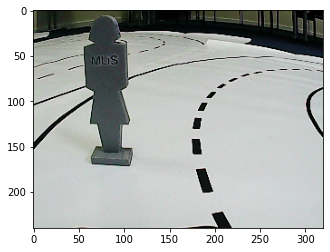

In [9]:
image_index = 21
plt.imshow(Image.open(cleaned_df['image_path'][image_index]))
print("image_path: %s" % cleaned_df['image_path'][image_index])
print("steering_Angle: %f" % cleaned_df['angle'][image_index])
print("speed: %d" % cleaned_df['speed'][image_index])

(array([3390.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        10403.0000]),
 array([0.0000, 0.0400, 0.0800, 0.1200, 0.1600, 0.2000, 0.2400, 0.2800,
        0.3200, 0.3600, 0.4000, 0.4400, 0.4800, 0.5200, 0.5600, 0.6000,
        0.6400, 0.6800, 0.7200, 0.7600, 0.8000, 0.8400, 0.8800, 0.9200,
        0.9600, 1.0000]),
 <BarContainer object of 25 artists>)

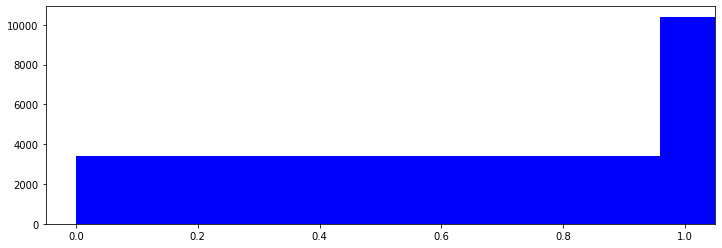

In [10]:
# Look at the distribution of speed
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(cleaned_df['speed'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(cleaned_df['speed'], bins=num_of_bins, width=1, color='blue')

Training data: 9655
Validation data: 4138


Text(0.5, 1.0, 'Validation Data')

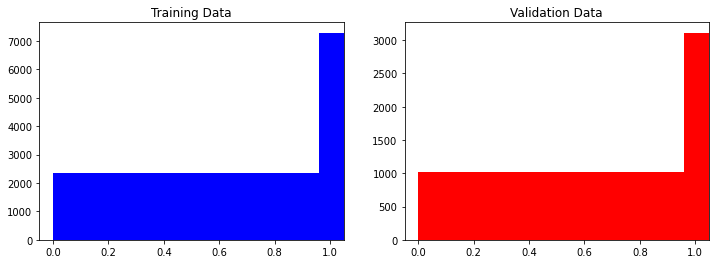

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df['image_path'].to_list(), cleaned_df['speed'].to_list(), test_size=0.3)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

In [20]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'processed')

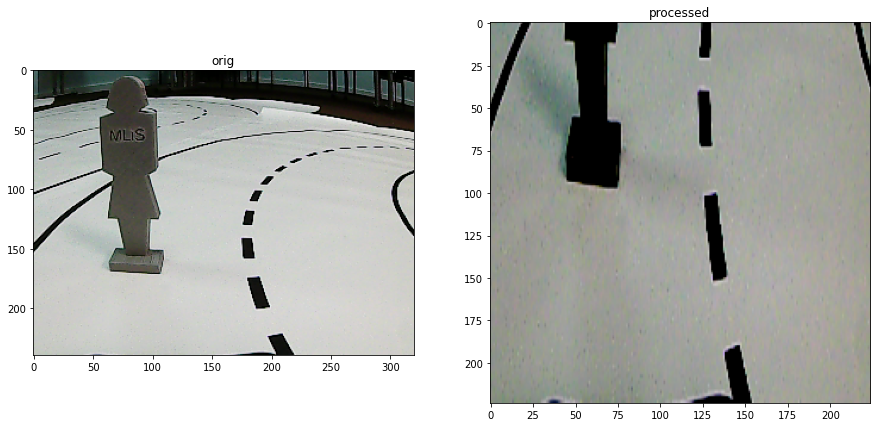

In [21]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]
    image = cv2.resize(image, (224,224)) 
    return tf.keras.applications.mobilenet_v2.preprocess_input(image)
    #height, _, _ = image.shape
    #image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    #image = cv2.GaussianBlur(image, (3,3), 0)


    # kernel = np.array([
    #     [-1, -1, -1],
    #     [-1, 8, -1],
    #     [-1, -1, -1]
    #     ])
    # image = cv2.filter2D(image, -1, kernel)

    # input image size (200,66) Nvidia model
    #image_array_new = image.img_to_array(image)
    #image_array_new_dimension = np.expand_dims(image_array_new,axis=0)
    #image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(cleaned_df['image_path'][image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [22]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


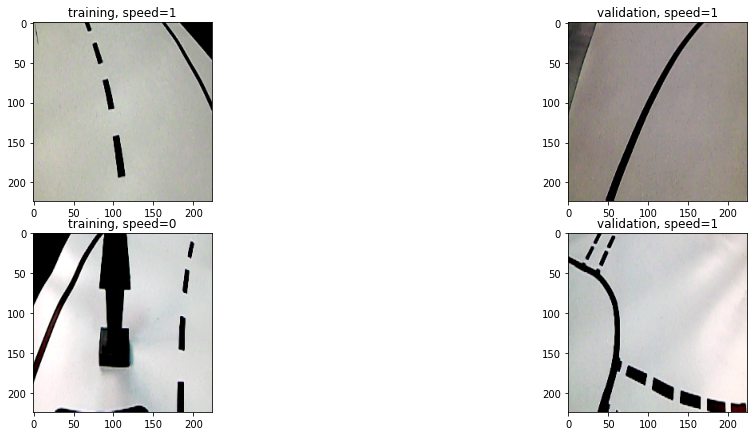

In [23]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, speed=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, speed=%s" % y_valid_batch[i])

In [29]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'sigmoid'))
    model.layers[0].trainable = False

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.99),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model
    
#     model = Sequential(name='Nvidia_Model')
#     model.add(tf.keras.applications.resnet50.ResNet50(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=(224,224,3),
#     pooling=None,
#     classes=1000
# ))
    
#     def preprocess(image):
#         image = tf.cast(image, tf.float32)
#         image = tf.image.resize(image, (224, 224))
#         image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
#         image = image[None, ...]
#         return image

# # Helper function to extract labels from probability vector
#     def get_imagenet_label(probs):
#         return decode_predictions(probs, top=1)[0][0]
    
    
    
    
    # initial_learning_rate = 0.1
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    # initial_learning_rate,
    # decay_steps=100000,
    # decay_rate=0.9,
    # staircase=True)

    # initial_learning_rate = 0.1
    # decay_steps = 1.0
    # decay_rate = 0.5
    # learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
    # initial_learning_rate, decay_steps, decay_rate)

    # model.compile(optimizer=tf.keras.optimizers.SGD(
    #               learning_rate=learning_rate_fn),
    #           loss='sparse_categorical_crossentropy',
    #           metrics=['accuracy'])

    

    
    
    # model.compile(tf.keras.optimizers.Adam(
    # learning_rate=lr_schedule,
    # beta_1=0.9,
    # beta_2=0.999,
    # epsilon=1e-08,
    # amsgrad=False,
    # name='Adam',
    # ),loss='binary_crossentropy',metrics=['accuracy'])
    
    
    #model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001), loss='binary_crossentropy', metrics='accuracy')

In [30]:
model = nvidia_model()
model.summary()

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
model_output_dir = './speed'

# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs'
#!rm -rf $log_dir_root

# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'),
    verbose=1,
    save_best_only=True
)

In [34]:
history = model.fit(
    image_data_generator(X_train, y_train, batch_size=32),
    steps_per_epoch=3*301,
    epochs=30,
    validation_data = image_data_generator(X_valid, y_valid, batch_size=32),
    validation_steps=3*129,
    callbacks=checkpoint_callback
)

Epoch 1/30
903/903 [==============================] - 94s 104ms/step - loss: 0.1750 - accuracy: 0.9300 - val_loss: 0.1772 - val_accuracy: 0.9237

Epoch 00001: val_loss improved from inf to 0.17721, saving model to ./speed/lane_navigation_check.h5
Epoch 2/30
  1/903 [..............................] - ETA: 20s - loss: 0.0670 - accuracy: 0.9688

/home/ppxst3/anaconda3/envs/my_env/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


903/903 [==============================] - 95s 105ms/step - loss: 0.1481 - accuracy: 0.9391 - val_loss: 0.1548 - val_accuracy: 0.9357

Epoch 00002: val_loss improved from 0.17721 to 0.15482, saving model to ./speed/lane_navigation_check.h5
Epoch 3/30
903/903 [==============================] - 90s 100ms/step - loss: 0.1354 - accuracy: 0.9437 - val_loss: 0.1524 - val_accuracy: 0.9352

Epoch 00003: val_loss improved from 0.15482 to 0.15240, saving model to ./speed/lane_navigation_check.h5
Epoch 4/30
903/903 [==============================] - 91s 100ms/step - loss: 0.1273 - accuracy: 0.9480 - val_loss: 0.1354 - val_accuracy: 0.9430

Epoch 00004: val_loss improved from 0.15240 to 0.13541, saving model to ./speed/lane_navigation_check.h5
Epoch 5/30
903/903 [==============================] - 92s 102ms/step - loss: 0.1172 - accuracy: 0.9514 - val_loss: 0.1376 - val_accuracy: 0.9432

Epoch 00005: val_loss did not improve from 0.13541
Epoch 6/30
903/903 [==============================] - 92s 102

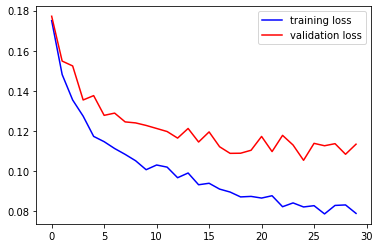

In [35]:

history
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

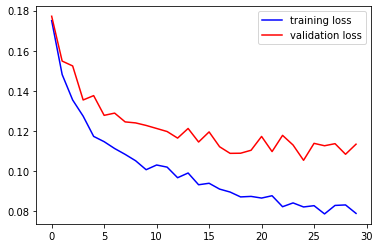

In [36]:
history
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [37]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mse       = 0.023
r_squared = 89.02%



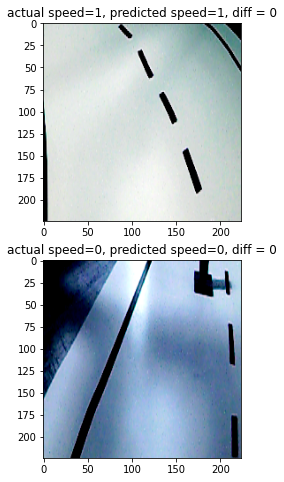

In [38]:
n_tests = 500
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)
y_pred = [1 if x>0.5 else 0 for x in y_pred]
n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual speed={y_test[i]}, predicted speed={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")